Verify that the direct TMS stim works as intended

Components to verify:
 - Probability parameter in drives works as expected
 - Direct stim of soma works as expected

Also tune direct stim to soma so that it spikes quickly (brief, strong current injection)
 - Direct activation should also override any hyperpolarization that the cell is experiencing so that a spike is registered (that's the whole point)

Base code from [Nick Tolley's Animating HNN Simulations tutorial](https://jonescompneurolab.github.io/textbook/content/08_using_hnn_api/animating_hnn_simulations.html)

In [1]:
import os.path as op

import matplotlib.pyplot as plt
%matplotlib ipympl

import hnn_core
from hnn_core import jones_2009_model, simulate_dipole, read_params
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.viz import NetworkPlotter
from copy import deepcopy


In [2]:
def drive_sim(mesh_shape=(1, 1), clear_connectivity=True, distal=None, direct=None, tstop=50, trace=True, movie=False):
    net = jones_2009_model(mesh_shape=mesh_shape)
    if clear_connectivity:
        net.clear_connectivity() # To isolate the effects of the stimulation

    # Note that we move the cells further apart to allow better visualization of
    # the network (default inplane_distance=1.0 µm).
    net.set_cell_positions(inplane_distance=300)
    
    if distal is not None:
        # Add distal w/ probability
        net.add_evoked_drive(**distal)
    if direct is not None:
        # Edit syns of each pyramidal cell soma to be able to receive ampa and nmda synapse approximating backpropagating AP from axon
        net.cell_types['L2_pyramidal'].sections['soma'].syns = ['gabaa', 'gabab', 'ampa', 'nmda']
        net.cell_types['L5_pyramidal'].sections['soma'].syns = ['gabaa', 'gabab', 'ampa', 'nmda']
        # Add direct w/ cell-type specific probability
        net.add_evoked_drive(**direct)

    dpl = simulate_dipole(net, tstop=tstop, record_vsec='all')

    if trace:
        fig, ax = plt.subplots()
        times = net.cell_response._times
        vsec = net.cell_response._vsec[0]
        for cell in vsec.values(): ax.plot(times, cell['soma'])
        ax.legend(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal'])
        # print(net.cell_response.spike_times)
    if movie:
        net_plot = NetworkPlotter(net)  # Reinitialize plotter with simulated network
        net_plot.xlim = (400, 1600)
        net_plot.ylim = (400, 1600)
        net_plot.zlim = (-500, 1600)
        net_plot.azim = 225
        if type(movie) is str:
            net_plot.export_movie(f'verification_gifs/{movie}.gif', dpi=100, fps=30, interval=100)
        else:
            net_plot.export_movie('verification_gifs/tms_direct.gif', dpi=100, fps=30, interval=100)
        return net_plot

In [6]:
distal = dict(
    name="tms_distal",
    mu=0.5,
    sigma=0,
    numspikes=1,
    location="distal",
    # n_drive_cells=None,
    # cell_specific=None,
    weights_ampa={'L2_basket': 0.0024741719999999997, 'L2_pyramidal': 0.0031460039999999996, 'L5_pyramidal': 0.030831731999999997},
    weights_nmda={'L2_basket': 0.039215124, 'L2_pyramidal': 0.004143708, 'L5_pyramidal': 0.006008543999999999},
    space_constant=1e6, # Every point in space should be equivalent; large constant effectively does this
    synaptic_delays={'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_pyramidal': 0.1},
    probability=1,)

direct = dict(
    name="tms_direct",
    mu=0.5, # Tune
    sigma=0, # Tune
    numspikes=1,
    location="soma",
    # n_drive_cells=None,
    # cell_specific=None,
    weights_ampa=   {'L2_basket':    0.002, 
                     'L2_pyramidal': 0.003, 
                     'L5_basket':    0.002,
                     'L5_pyramidal': 0.03}, # Tune to mimic real cell response 
    weights_nmda=   {'L2_basket':    0.0, 
                     'L2_pyramidal': 0.0, 
                     'L5_basket':    0.0,
                     'L5_pyramidal': 0.0}, # Make 0; probably want to just do ampa
    space_constant=1e6, # Every point in space should be equivalent; large constant effectively does this
    synaptic_delays=0., # Maybe should be 0
    probability=    {'L2_basket':    0.01,
                     'L2_pyramidal': 0.01,
                     'L5_basket':    0.01,
                     'L5_pyramidal': 0.01}, # Tune
)

Distal drive works; current travels down dendrites

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/jacobtajchman/Documents/GitHub/hnn_tms_direct/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...


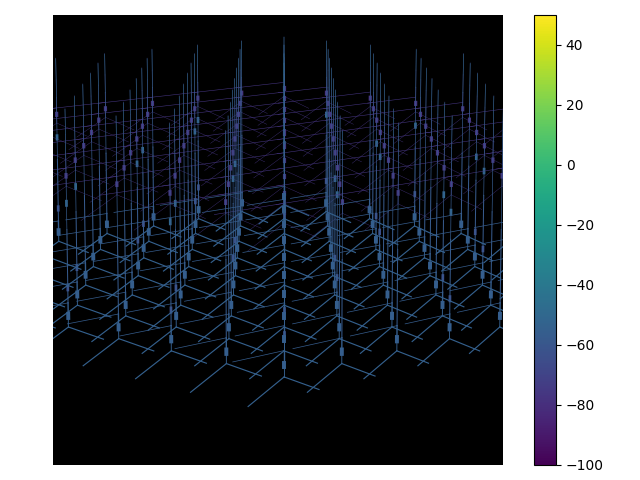

In [4]:
distal_c = deepcopy(distal)
distal_c['probability'] = 1.
net_plot = drive_sim(mesh_shape=(10, 10), 
                     clear_connectivity=True, 
                     distal=distal_c, 
                     direct=None, 
                     tstop=10, 
                     trace=False, 
                     movie='distal_1')

Distal drive can be modulated by the probability parameter

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...


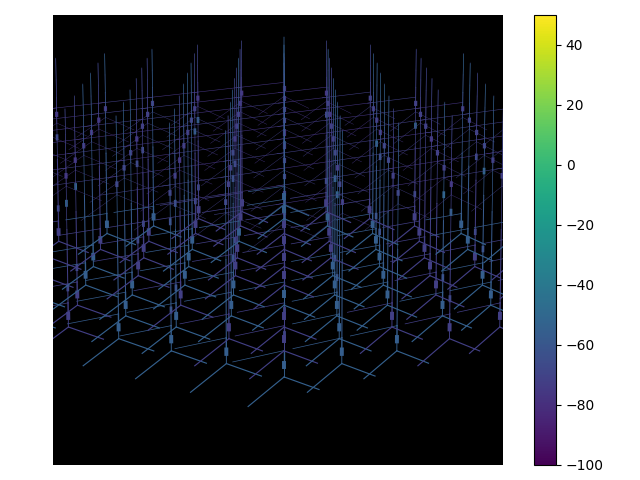

In [5]:
distal_c = deepcopy(distal)
distal_c['probability'] = 0.5
net_plot = drive_sim(mesh_shape=(10, 10), 
                     clear_connectivity=True, 
                     distal=distal_c, 
                     direct=None, 
                     tstop=10, 
                     trace=False, 
                     movie='distal_0-5')

Direct drive works; current travels up dendrites from soma

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...


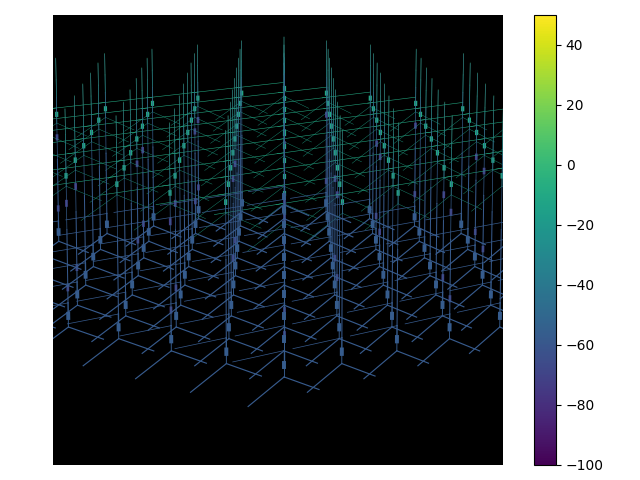

In [16]:
direct_c = deepcopy(direct)
direct_c['probability'] = 1.
net_plot = drive_sim(mesh_shape=(10, 10), 
                     clear_connectivity=True, 
                     distal=None, 
                     direct=direct_c, 
                     tstop=10, 
                     trace=False, 
                     movie='direct_1')

Direct drive can be modulated by the probability parameter

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...


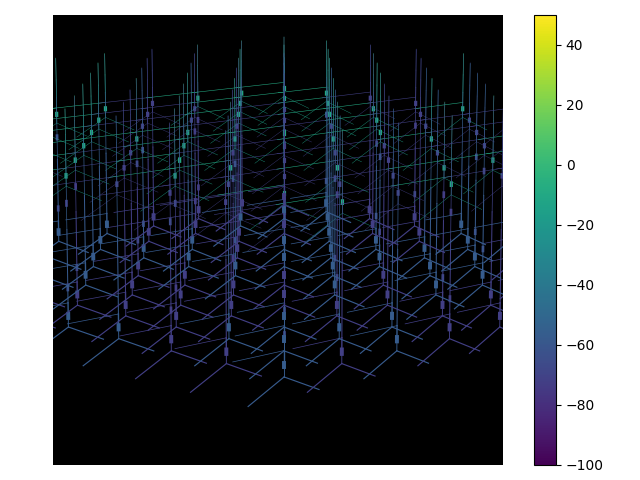

In [17]:
direct_c = deepcopy(direct)
direct_c['probability'] = 0.5
net_plot = drive_sim(mesh_shape=(10, 10), 
                     clear_connectivity=True, 
                     distal=None, 
                     direct=direct_c, 
                     tstop=10, 
                     trace=False, 
                     movie='direct_0-5')

Direct drive works and can be targeted to each cell type using the probability parameter

L2_basket

{'name': 'tms_direct', 'mu': 0.5, 'sigma': 0, 'numspikes': 1, 'location': 'soma', 'weights_ampa': {'L2_basket': 0.002, 'L2_pyramidal': 0.003, 'L5_basket': 0.002, 'L5_pyramidal': 0.03}, 'weights_nmda': {'L2_basket': 0.0, 'L2_pyramidal': 0.0, 'L5_basket': 0.0, 'L5_pyramidal': 0.0}, 'space_constant': 1000000.0, 'synaptic_delays': 0.0, 'probability': {'L2_basket': 1.0, 'L2_pyramidal': 0.01, 'L5_basket': 0.01, 'L5_pyramidal': 0.01}}
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


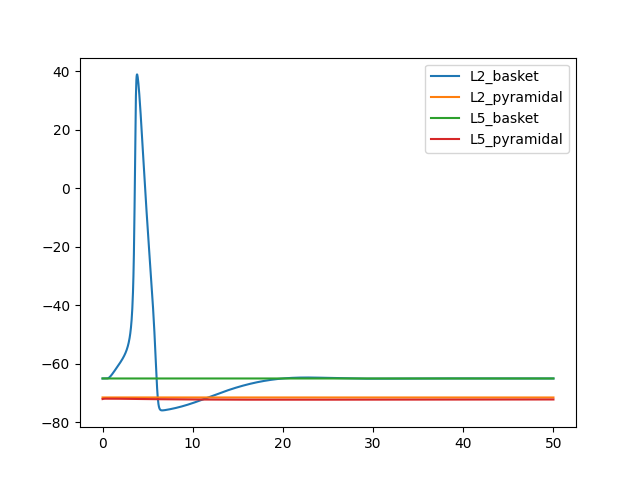

In [ ]:
direct_c = deepcopy(direct)
direct_c['probability']['L2_basket'] = 1.
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=True, 
                     distal=None, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=True, 
                     movie=False)

L2_pyramidal

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


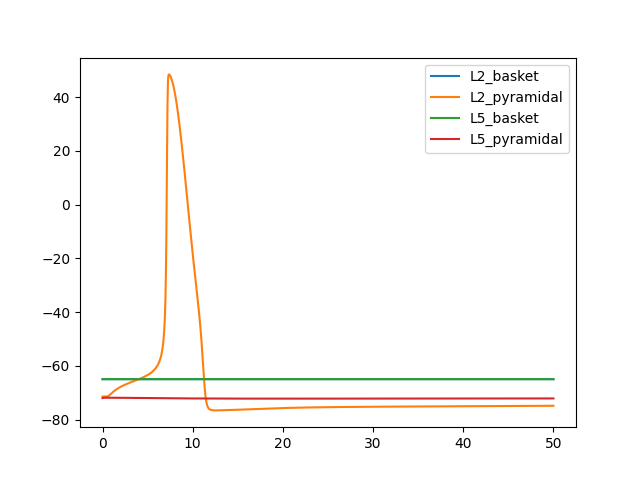

In [11]:
direct_c = deepcopy(direct)
direct_c['probability']['L2_pyramidal'] = 1.
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=True, 
                     distal=None, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=True, 
                     movie=False)

L5_basket

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


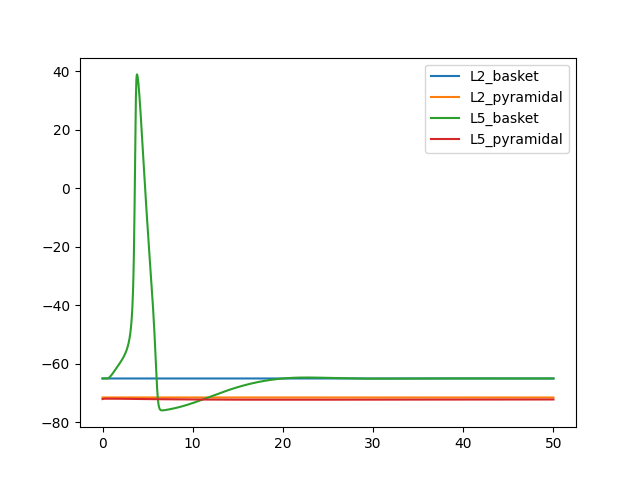

In [12]:
direct_c = deepcopy(direct)
direct_c['probability']['L5_basket'] = 1.
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=True, 
                     distal=None, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=True, 
                     movie=False)

But it causes L5_pyramidal cells to spike multiple times

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


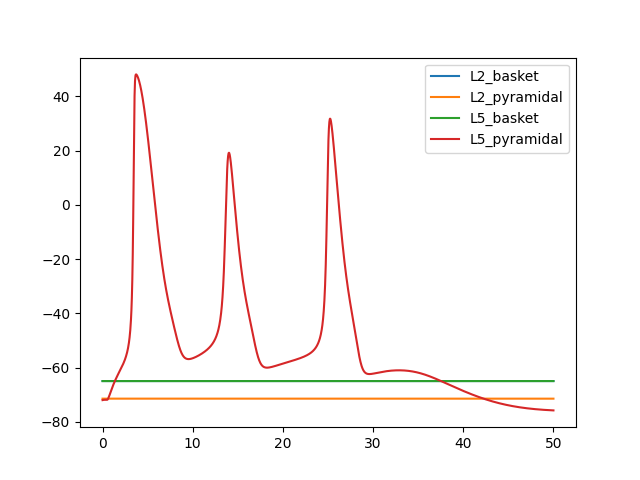

In [13]:
direct_c = deepcopy(direct)
direct_c['probability']['L5_pyramidal'] = 1.
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=True, 
                     distal=None, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=True, 
                     movie=False)

The multiple spikes are due to the AMPA synapse causing depolarization over a long period of time, shown clearly when the depolarization is subthreshold

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


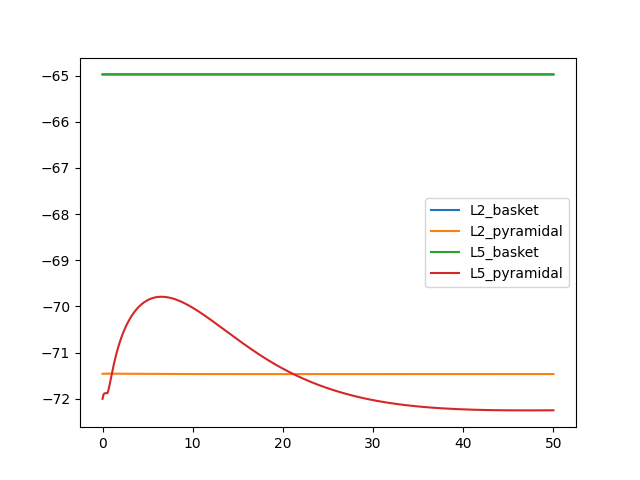

In [14]:
direct_c = deepcopy(direct)
direct_c['probability']['L5_pyramidal'] = 1.
direct_c['weights_ampa']['L5_pyramidal'] = 0.003
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=True, 
                     distal=None, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=True, 
                     movie=False)

NMDA synapses work similarly

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


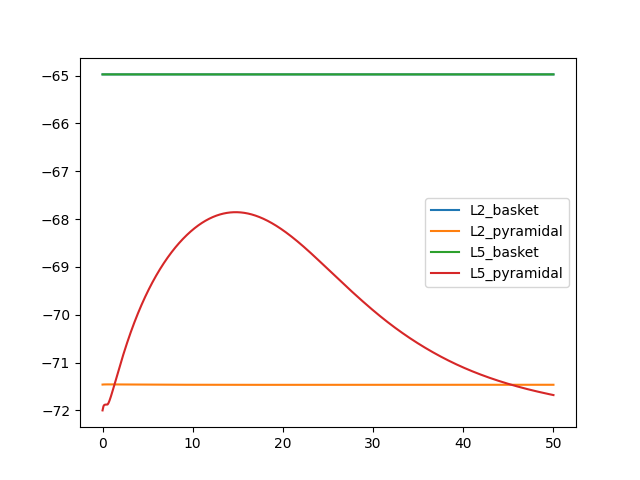

In [18]:
direct_c = deepcopy(direct)
direct_c['probability']['L5_pyramidal'] = 1.
direct_c['weights_ampa']['L5_pyramidal'] = 0.0
direct_c['weights_nmda']['L5_pyramidal'] = 0.003
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=True, 
                     distal=None, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=True, 
                     movie=False)

Need to use a current clamp to get the brief depolarization to cause single, reliable spiking. This should be possible with a tonic bias in HNN, but it does not have the same "probability" functionality that evoked drives do. This necessitates adding this functionality into the HNN source code.